# Sentimental analysis using GRU and LSTM
## Mengxi Han
## Rohan Jalan

In [1]:
#import system libraries to download and work with datafile
import sys
import os
import urllib.request
import tarfile
import zipfile
import os
import glob

In [2]:
#import remaining libraries
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cdist

In [3]:
#import keras packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
#download and extract data from url link
def readurldata(url, download_dir):



    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)


    if not os.path.exists(file_path):
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
            
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has already been downloaded.")

In [5]:
#read data from downloaded file
def readdata(path):
    with open(path, 'rt', encoding='utf-8') as file:
        lines = file.readlines()
        text = " ".join(lines)
    return text

In [6]:
#create paths for all the reviews
def loaddata(train=True):

    
    trainortest = "train" if train else "test"

 
    dir_base = os.path.join(data_dir, "aclImdb", trainortest)
    
    path_positive = os.path.join(dir_base, "pos", "*.txt")
    path_negative = os.path.join(dir_base, "neg", "*.txt")

    path_posx = glob.glob(path_positive)
    path_negx = glob.glob(path_negative)

    data_positive = [readdata(path) for path in path_posx]
    data_negative = [readdata(path) for path in path_negx]

    x = data_positive + data_negative

    y = [1.0] * len(data_positive) + [0.0] * len(data_negative)

    return x, y

In [7]:
#define data directory and url link
data_dir = "moviedata/"

data_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [8]:
#call function to download and extract data from url to directory
readurldata(data_url,data_dir)

Download finished. Extracting files.
Done.


In [9]:
#load train and test dataset with text as x and class as y
x_train, y_train = loaddata(train=True)
x_test, y_test = loaddata(train=False)

# Convert to numpy arrays.
y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
#priny number of train and test data
print("Train data size: ", len(x_train))
print("Test data size:  ", len(x_test))

Train data size:  25000
Test data size:   25000


In [11]:
#combine train and text for creating vocaulary and processing
data= x_train + x_test

In [12]:
#define tokenizer
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

In [13]:
#load tokenizer on our data
tokenizer.fit_on_texts(data)

In [14]:
#trains tokens for training data
x_train_tokens = tokenizer.texts_to_sequences(x_train)

In [15]:
#train tokens for test data
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [16]:
#count the total number of tokens
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [17]:
#define max permissible tokens as mean plus 2 standard deviations
max_tokens = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
max_tokens

544

In [18]:
#provide padding to text
pad = 'pre'

In [19]:
#pad training data
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

In [20]:
#pad test data
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

In [21]:
#check train shape
x_train_pad.shape

(25000, 544)

In [22]:
#check test shape
x_test_pad.shape

(25000, 544)

In [23]:
#map integer tokens back to words
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [24]:
#map integer tokens back to words
def tokens_to_string(x):
    words = [inverse_map[y] for y in x if y != 0]
    text = " ".join(words)
    return text

In [25]:
#define our model. GRU with dropout.
model = Sequential()
embedding_size = 8
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))
model.add(GRU(units=16,dropout=0.2,return_sequences=True))
model.add(GRU(units=8,dropout=0.2,return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 544, 8)            80000     
_________________________________________________________________
gru (GRU)                    (None, 544, 16)           1248      
_________________________________________________________________
gru_1 (GRU)                  (None, 544, 8)            624       
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 82,045
Trainable params: 82,045
Non-trainable params: 0
_________________________________________________________________


In [26]:
#train our model
model.fit(x_train_pad, y_train,
          validation_split=0.1, epochs=10, batch_size=128)

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 84s 4ms/sample - loss: 0.6072 - accuracy: 0.6472 - val_loss: 0.4209 - val_accuracy: 0.8520
Epoch 2/10
22500/22500 [==============================] - 78s 3ms/sample - loss: 0.3786 - accuracy: 0.8418 - val_loss: 0.3043 - val_accuracy: 0.8952
Epoch 3/10
22500/22500 [==============================] - 78s 3ms/sample - loss: 0.2873 - accuracy: 0.8883 - val_loss: 0.2989 - val_accuracy: 0.8828
Epoch 4/10
22500/22500 [==============================] - 81s 4ms/sample - loss: 0.2314 - accuracy: 0.9152 - val_loss: 0.2618 - val_accuracy: 0.8984
Epoch 5/10
22500/22500 [==============================] - 84s 4ms/sample - loss: 0.1982 - accuracy: 0.9314 - val_loss: 0.3613 - val_accuracy: 0.8672
Epoch 6/10
22500/22500 [==============================] - 83s 4ms/sample - loss: 0.1691 - accuracy: 0.9435 - val_loss: 0.3855 - val_accuracy: 0.8576
Epoch 7/10
22500/22500 [==============================] -

In [27]:
#evaluate our model
result = model.evaluate(x_test_pad, y_test)

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [28]:
#print accuracy of our model evaluation.
print("Accuracy: ",result[1])

Accuracy:  0.85488


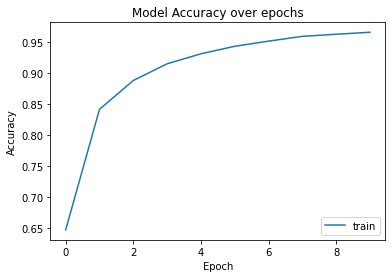

In [29]:
# summarize history for accuracy over epochs
plt.plot(model.history.history['accuracy'])
plt.title('Model Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='lower right')
plt.show()

In [30]:
#get layer embedding from model
layer_embedding = model.get_layer('layer_embedding')
weights_embedding = layer_embedding.get_weights()[0]

In [31]:
#create function to fine n nummber of similar and dissimilar words
def similarwords(word,num, metric='cosine'):

    token = tokenizer.word_index[word]

    embedding = weights_embedding[token]

    distances = cdist(weights_embedding, [embedding],
                      metric=metric).T[0]
    
    sorted_index = np.argsort(distances)
    
    sorted_distances = distances[sorted_index]
    
    sorted_words = [inverse_map[token] for token in sorted_index
                    if token != 0]
    k = num

    print("Distance from '{0}':".format(word))
    
    print("most similar ", k, " words are:")
    for word, distance in zip(sorted_words[0:k], sorted_distances[0:k]):
            print("{0:.3f} - {1}".format(distance, word))
            
    print("least similar ", k, " words are:")
    for word, distance in zip(sorted_words[-k:], sorted_distances[-k:]):
            print("{0:.3f} - {1}".format(distance, word))


In [32]:
#find n words similar to user provided word.
#provided word has to be in vocabulary
more = "y"
while more != "n":
    a = input("Enter word to find similar: ")
    b = int(input("Enter number of words to find: "))
    similarwords(a, b, metric='cosine')
    more = input("do you want to test more? (y/n)")

Enter word to find similar: good
Enter number of words to find: 3
Distance from 'good':
most similar  3  words are:
0.000 - good
0.026 - position
0.028 - lupino
least similar  3  words are:
1.981 - wwii
1.988 - denver
1.988 - emphasize
do you want to test more? (y/n)y
Enter word to find similar: horrible
Enter number of words to find: 3
Distance from 'horrible':
most similar  3  words are:
0.000 - horrible
0.005 - downright
0.005 - vapid
least similar  3  words are:
1.993 - futuristic
1.994 - allowing
1.995 - email
do you want to test more? (y/n)y
Enter word to find similar: awesome
Enter number of words to find: 3
Distance from 'awesome':
most similar  3  words are:
0.000 - awesome
0.009 - consisting
0.010 - guilt
least similar  3  words are:
1.990 - film's
1.993 - manipulative
1.993 - eternal
do you want to test more? (y/n)n


In [33]:
#define our model. GRU without dropout.
modela = Sequential()
embedding_size = 8
modela.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))
modela.add(GRU(units=16,return_sequences=True))
modela.add(GRU(units=8,return_sequences=True))
modela.add(GRU(units=4))
modela.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)
modela.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
modela.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 544, 8)            80000     
_________________________________________________________________
gru_3 (GRU)                  (None, 544, 16)           1248      
_________________________________________________________________
gru_4 (GRU)                  (None, 544, 8)            624       
_________________________________________________________________
gru_5 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 82,045
Trainable params: 82,045
Non-trainable params: 0
_________________________________________________________________


In [34]:
#train our model
modela.fit(x_train_pad, y_train,
          validation_split=0.1, epochs=10, batch_size=128)

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 83s 4ms/sample - loss: 0.5944 - accuracy: 0.6586 - val_loss: 0.3560 - val_accuracy: 0.8888
Epoch 2/10
22500/22500 [==============================] - 85s 4ms/sample - loss: 0.3465 - accuracy: 0.8632 - val_loss: 0.3798 - val_accuracy: 0.8504
Epoch 3/10
22500/22500 [==============================] - 83s 4ms/sample - loss: 0.2601 - accuracy: 0.9085 - val_loss: 0.4728 - val_accuracy: 0.8056
Epoch 4/10
22500/22500 [==============================] - 78s 3ms/sample - loss: 0.2117 - accuracy: 0.9316 - val_loss: 0.3472 - val_accuracy: 0.8656
Epoch 5/10
22500/22500 [==============================] - 82s 4ms/sample - loss: 0.1800 - accuracy: 0.9439 - val_loss: 0.4954 - val_accuracy: 0.8164
Epoch 6/10
22500/22500 [==============================] - 80s 4ms/sample - loss: 0.1558 - accuracy: 0.9539 - val_loss: 0.5714 - val_accuracy: 0.8148
Epoch 7/10
22500/22500 [==============================] -

In [35]:
#evaluate our model
resulta = modela.evaluate(x_test_pad, y_test)

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [36]:
#print accuracy of our model evaluation.
print("Accuracy: ",resulta[1])

Accuracy:  0.8404


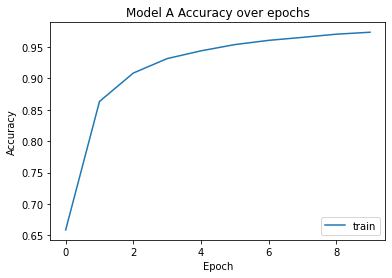

In [37]:
# summarize history for accuracy over epochs
plt.plot(modela.history.history['accuracy'])
plt.title('Model A Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='lower right')
plt.show()

In [38]:
#define our model. LSTM with dropout.
modelb = Sequential()
embedding_size = 8
modelb.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))
modelb.add(LSTM(units=16,dropout=0.2,return_sequences=True))
modelb.add(LSTM(units=8,dropout=0.2,return_sequences=True))
modelb.add(LSTM(units=4))
modelb.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)
modelb.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
modelb.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 544, 8)            80000     
_________________________________________________________________
lstm (LSTM)                  (None, 544, 16)           1600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 544, 8)            800       
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 82,613
Trainable params: 82,613
Non-trainable params: 0
_________________________________________________________________


In [39]:
#train our model
modelb.fit(x_train_pad, y_train,
          validation_split=0.1, epochs=10, batch_size=128)

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 92s 4ms/sample - loss: 0.5555 - accuracy: 0.7100 - val_loss: 0.4123 - val_accuracy: 0.8744
Epoch 2/10
22500/22500 [==============================] - 91s 4ms/sample - loss: 0.3162 - accuracy: 0.8815 - val_loss: 0.3863 - val_accuracy: 0.8412
Epoch 3/10
22500/22500 [==============================] - 91s 4ms/sample - loss: 0.2375 - accuracy: 0.9163 - val_loss: 0.5798 - val_accuracy: 0.7748
Epoch 4/10
22500/22500 [==============================] - 92s 4ms/sample - loss: 0.1901 - accuracy: 0.9342 - val_loss: 0.3112 - val_accuracy: 0.8748
Epoch 5/10
22500/22500 [==============================] - 92s 4ms/sample - loss: 0.1599 - accuracy: 0.9492 - val_loss: 0.2674 - val_accuracy: 0.9060
Epoch 6/10
22500/22500 [==============================] - 92s 4ms/sample - loss: 0.1426 - accuracy: 0.9547 - val_loss: 0.4373 - val_accuracy: 0.8484
Epoch 7/10
22500/22500 [==============================] -

In [40]:
#evaluate our model
resultb = modelb.evaluate(x_test_pad, y_test)

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [41]:
#print accuracy of our model evaluation.
print("Accuracy: ",resultb[1])

Accuracy:  0.85404


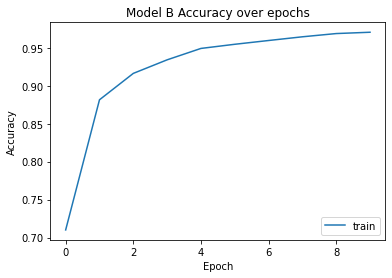

In [42]:
# summarize history for accuracy over epochs
plt.plot(modelb.history.history['accuracy'])
plt.title('Model B Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='lower right')
plt.show()

In [43]:
#define our model. LSTM without dropout.
modelc = Sequential()
embedding_size = 8
modelc.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))
modelc.add(LSTM(units=16,return_sequences=True))
modelc.add(LSTM(units=8,return_sequences=True))
modelc.add(LSTM(units=4))
modelc.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)
modelc.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
modelc.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 544, 8)            80000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 544, 16)           1600      
_________________________________________________________________
lstm_4 (LSTM)                (None, 544, 8)            800       
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 82,613
Trainable params: 82,613
Non-trainable params: 0
_________________________________________________________________


In [44]:
#train our model
modelc.fit(x_train_pad, y_train,
          validation_split=0.1, epochs=10, batch_size=128)

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 100s 4ms/sample - loss: 0.6023 - accuracy: 0.6702 - val_loss: 0.5640 - val_accuracy: 0.8196
Epoch 2/10
22500/22500 [==============================] - 93s 4ms/sample - loss: 0.4074 - accuracy: 0.8349 - val_loss: 0.5627 - val_accuracy: 0.7756
Epoch 3/10
22500/22500 [==============================] - 94s 4ms/sample - loss: 0.3034 - accuracy: 0.8885 - val_loss: 0.5269 - val_accuracy: 0.7584
Epoch 4/10
22500/22500 [==============================] - 94s 4ms/sample - loss: 0.2341 - accuracy: 0.9188 - val_loss: 0.3260 - val_accuracy: 0.8756
Epoch 5/10
22500/22500 [==============================] - 96s 4ms/sample - loss: 0.1862 - accuracy: 0.9407 - val_loss: 0.3146 - val_accuracy: 0.8732
Epoch 6/10
22500/22500 [==============================] - 96s 4ms/sample - loss: 0.1543 - accuracy: 0.9532 - val_loss: 0.4197 - val_accuracy: 0.8468
Epoch 7/10
22500/22500 [==============================] 

In [45]:
#evaluate our model
resultc = modelc.evaluate(x_test_pad, y_test)

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [46]:
#print accuracy of our model evaluation.
print("Accuracy: ",resultc[1])

Accuracy:  0.85108


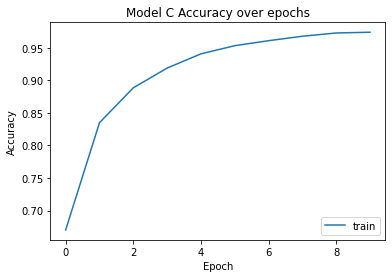

In [47]:
# summarize history for accuracy over epochs
plt.plot(modelc.history.history['accuracy'])
plt.title('Model C Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train'], loc='lower right')
plt.show()

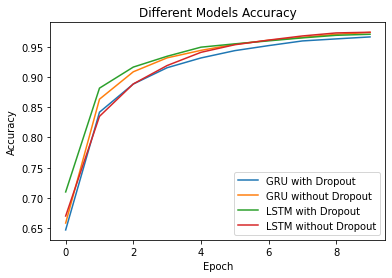

In [48]:
# summarize history for all models
plt.plot(model.history.history['accuracy'])
plt.plot(modela.history.history['accuracy'])
plt.plot(modelb.history.history['accuracy'])
plt.plot(modelc.history.history['accuracy'])
plt.title('Different Models Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['GRU with Dropout','GRU without Dropout','LSTM with Dropout','LSTM without Dropout'], loc='lower right')
plt.show()

In [49]:
#provide sentiment analysis on user input text.
more = "y"
while more != "n":
    a = input("provide sample text: ")
    sampletext = [a]
    tokens = tokenizer.texts_to_sequences(sampletext)
    tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)
    tokens_pad.shape
    print("Sentiment for GRU with Dropout :", model.predict(tokens_pad))
    print("Sentiment for GRU without Dropout :", modela.predict(tokens_pad))
    print("Sentiment for LSTM with Dropout :", modelb.predict(tokens_pad))
    print("Sentiment for LSTM without Dropout :", modelc.predict(tokens_pad))
    more = input("do you want to test more? (y/n)")

provide sample text: i hate this movie.
Sentiment for GRU with Dropout : [[0.52091223]]
Sentiment for GRU without Dropout : [[0.9784388]]
Sentiment for LSTM with Dropout : [[0.613088]]
Sentiment for LSTM without Dropout : [[0.11283041]]
do you want to test more? (y/n)y
provide sample text: i like this movie.
Sentiment for GRU with Dropout : [[0.7400263]]
Sentiment for GRU without Dropout : [[0.9831594]]
Sentiment for LSTM with Dropout : [[0.6614539]]
Sentiment for LSTM without Dropout : [[0.14169654]]
do you want to test more? (y/n)y
provide sample text: i love this movie.
Sentiment for GRU with Dropout : [[0.90989137]]
Sentiment for GRU without Dropout : [[0.9848074]]
Sentiment for LSTM with Dropout : [[0.7420932]]
Sentiment for LSTM without Dropout : [[0.19297671]]
do you want to test more? (y/n)y
provide sample text: i really like this movie.
Sentiment for GRU with Dropout : [[0.7312933]]
Sentiment for GRU without Dropout : [[0.9830284]]
Sentiment for LSTM with Dropout : [[0.6400958

In [51]:
print("The Accuracy on test sets are as follows :")
print("Accuracy for GRU with Dropout :", result[1])
print("Accuracy for GRU without Dropout :", resulta[1])
print("Accuracy for LSTM with Dropout :", resultb[1])
print("Accuracy for LSTM without Dropout :", resultc[1])

The Accuracy on test sets are as follows :
Accuracy for GRU with Dropout : 0.85488
Accuracy for GRU without Dropout : 0.8404
Accuracy for LSTM with Dropout : 0.85404
Accuracy for LSTM without Dropout : 0.85108
